[*********************100%***********************]  1 of 1 completed


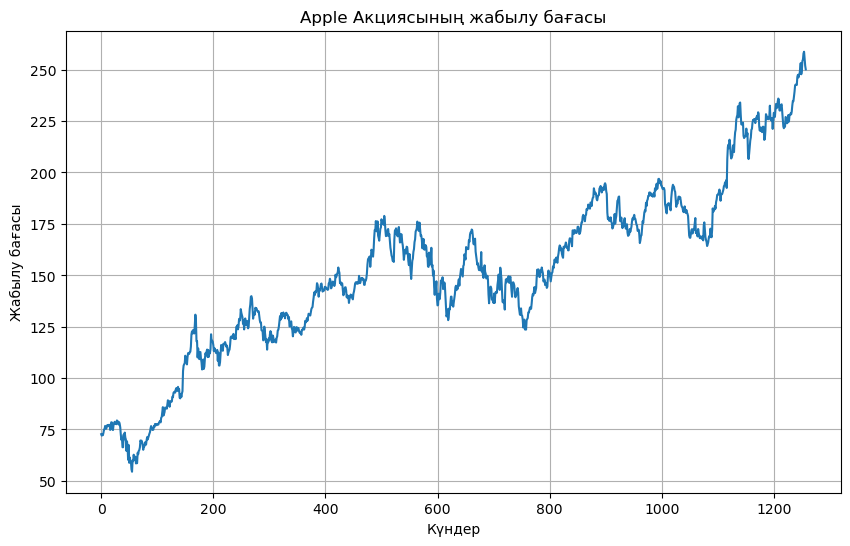

In [4]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# Apple компаниясының акция бағаларын жүктеу
data = yf.download('AAPL', start='2020-01-01', end='2025-01-01')

# 'Close' бағанын ғана аламыз
series = data['Close'].values

# Уақыт индексін құру
time = np.arange(len(series))

# Деректерді визуализациялау
plt.figure(figsize=(10,6))
plt.plot(time, series)
plt.title('Apple Акциясының жабылу бағасы')
plt.xlabel('Күндер')
plt.ylabel('Жабылу бағасы')
plt.grid(True)
plt.show()




In [5]:
# Бөлу нүктесі (мысалы, 80% train, 20% validation)
split_time = int(len(series) * 0.8)

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]


In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Уақыттық қатарды терезелеу"""
    series = tf.expand_dims(series, axis=-1)  # RNN үшін қосымша өлшем
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

# Гиперпараметрлер
window_size = 30
batch_size = 32
shuffle_buffer = 1000

# Train set дайындау
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer)


In [7]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size,1)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, activation="relu", padding='causal'),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)  # Массштабтау
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 30, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 30, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │         1,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,575 (267.87 KB)

 Trainable params: 68,575 (267.87 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 211.2174 - learning_rate: 1.0000e-08
Epoch 2/100
11/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 206.9042

C:\Users\14ken\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 203.0860 - learning_rate: 1.1220e-08
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 186.1902 - learning_rate: 1.2589e-08
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 169.1920 - learning_rate: 1.4125e-08
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 147.1792 - learning_rate: 1.5849e-08
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 129.4685 - learning_rate: 1.7783e-08
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 113.0256 - learning_rate: 1.9953e-08
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 98.8208 - learning_rate: 2.2387e-08
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 93.5685 - learning_rate: 2.5119e-08
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 86.6372 - learning_rate: 2.8184e-08
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 80.2531 - learning_rate: 3.1623e-08
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1

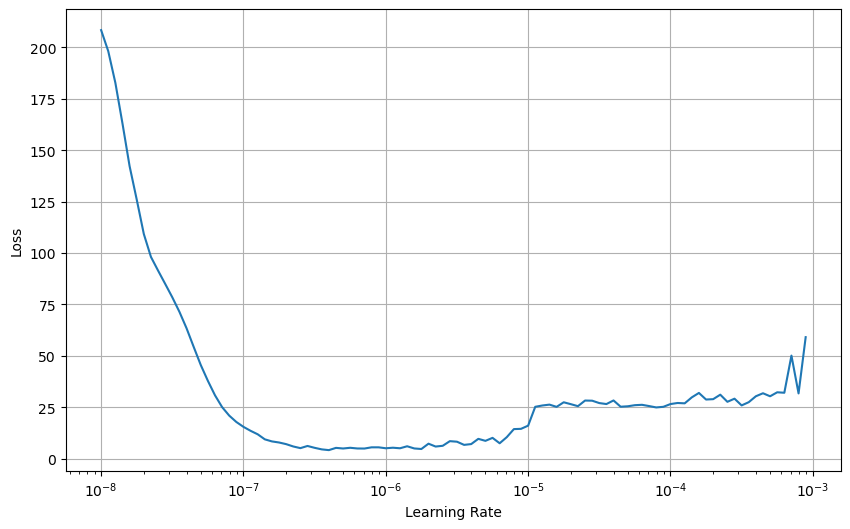

In [8]:
# Бастапқы салмақтарды сақтау
init_weights = model.get_weights()

# Learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20)
)

optimizer = tf.keras.optimizers.SGD(momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Learning rate tuning
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

# Learning rate графигі
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.figure(figsize=(10,6))
plt.semilogx(lrs, history.history["loss"])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 144.6084 - mae: 145.1079
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 19.9136 - mae: 20.4073
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 10.5486 - mae: 11.0344
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.7261 - mae: 7.2109
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.8420 - mae: 6.3199
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.9576 - mae: 7.4366
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.9641 - mae: 6.4525
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.2041 - mae: 5.6817
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.1102 - mae: 5.5880
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.2622 - mae: 6.7429
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.4856 - mae: 5.9708
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.5258 - mae: 6.0098
Epoch 13/100
31/3

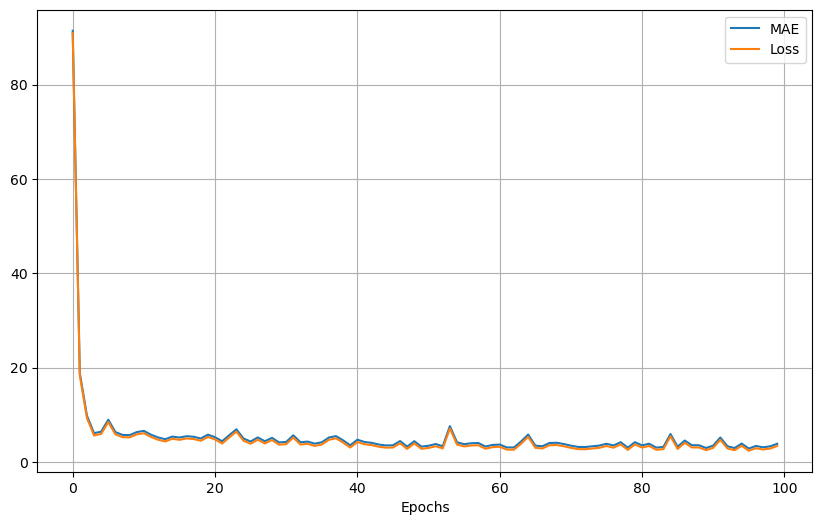

In [13]:
#Модельді қайта оқыту Keras сессиясын тазалау
tf.keras.backend.clear_session()
model.set_weights(init_weights)  # Алдыңғы салмақтарды қайта орнату

# Оңтайлы оқу жылдамдығы (мысалы, 1e-5)
learning_rate = 1e-6
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

# Модельді оқыту
history = model.fit(train_set, epochs=100)

# MAE және Loss графигі
mae = history.history['mae']
loss = history.history['loss']
epochs = range(len(loss))

plt.figure(figsize=(10,6))
plt.plot(epochs, mae, label='MAE')
plt.plot(epochs, loss, label='Loss')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.show()


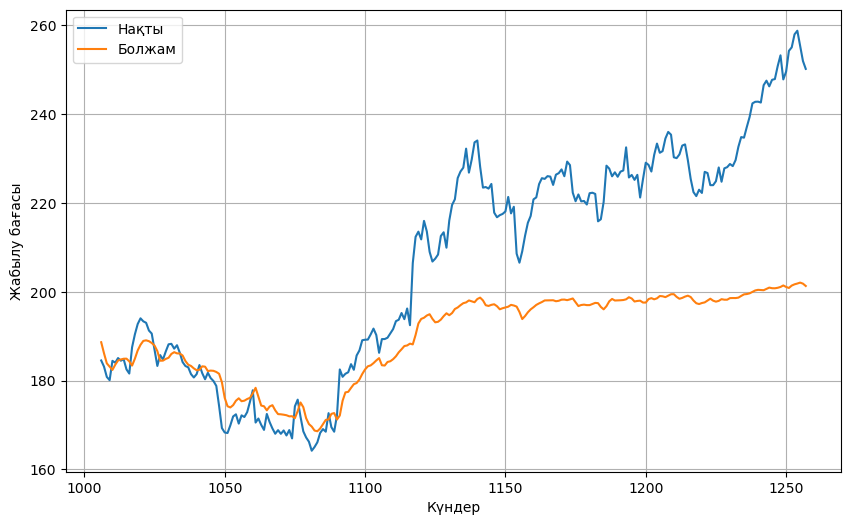

MAE: 26.991557891857237


In [15]:
# Forecast-тың ұзындығын дұрыстау
forecast = forecast[:len(x_valid)]

# Визуализация
plt.figure(figsize=(10,6))
plt.plot(time_valid, x_valid, label='Нақты')
plt.plot(time_valid, forecast, label='Болжам')
plt.xlabel('Күндер')
plt.ylabel('Жабылу бағасы')
plt.legend()
plt.grid(True)
plt.show()

# MAE есептеу (NumPy тәсілі)
mae = np.mean(np.abs(x_valid - forecast))
print(f"MAE: {mae}")
